9261
Setting Diff:  1  ->  (1, 926.1, 0.1, 0.01)
INIT: Volume 9261
INIT: target:  (1, 926.1, 0.1, 0.01)
INIT: Energy tensor(False)
if  tensor(True)  or  False flag:  False
self.energy.mean:  tensor(1.0244)
INIT: Wall tensor(False)
if  tensor(True)  or  False -> flag:  False
INIT: Risk tensor(False)
if  tensor(True)  or  False flag:  False
INIT: Death tensor(0.0010)
features.shape is:  torch.Size([5, 3, 21, 21])


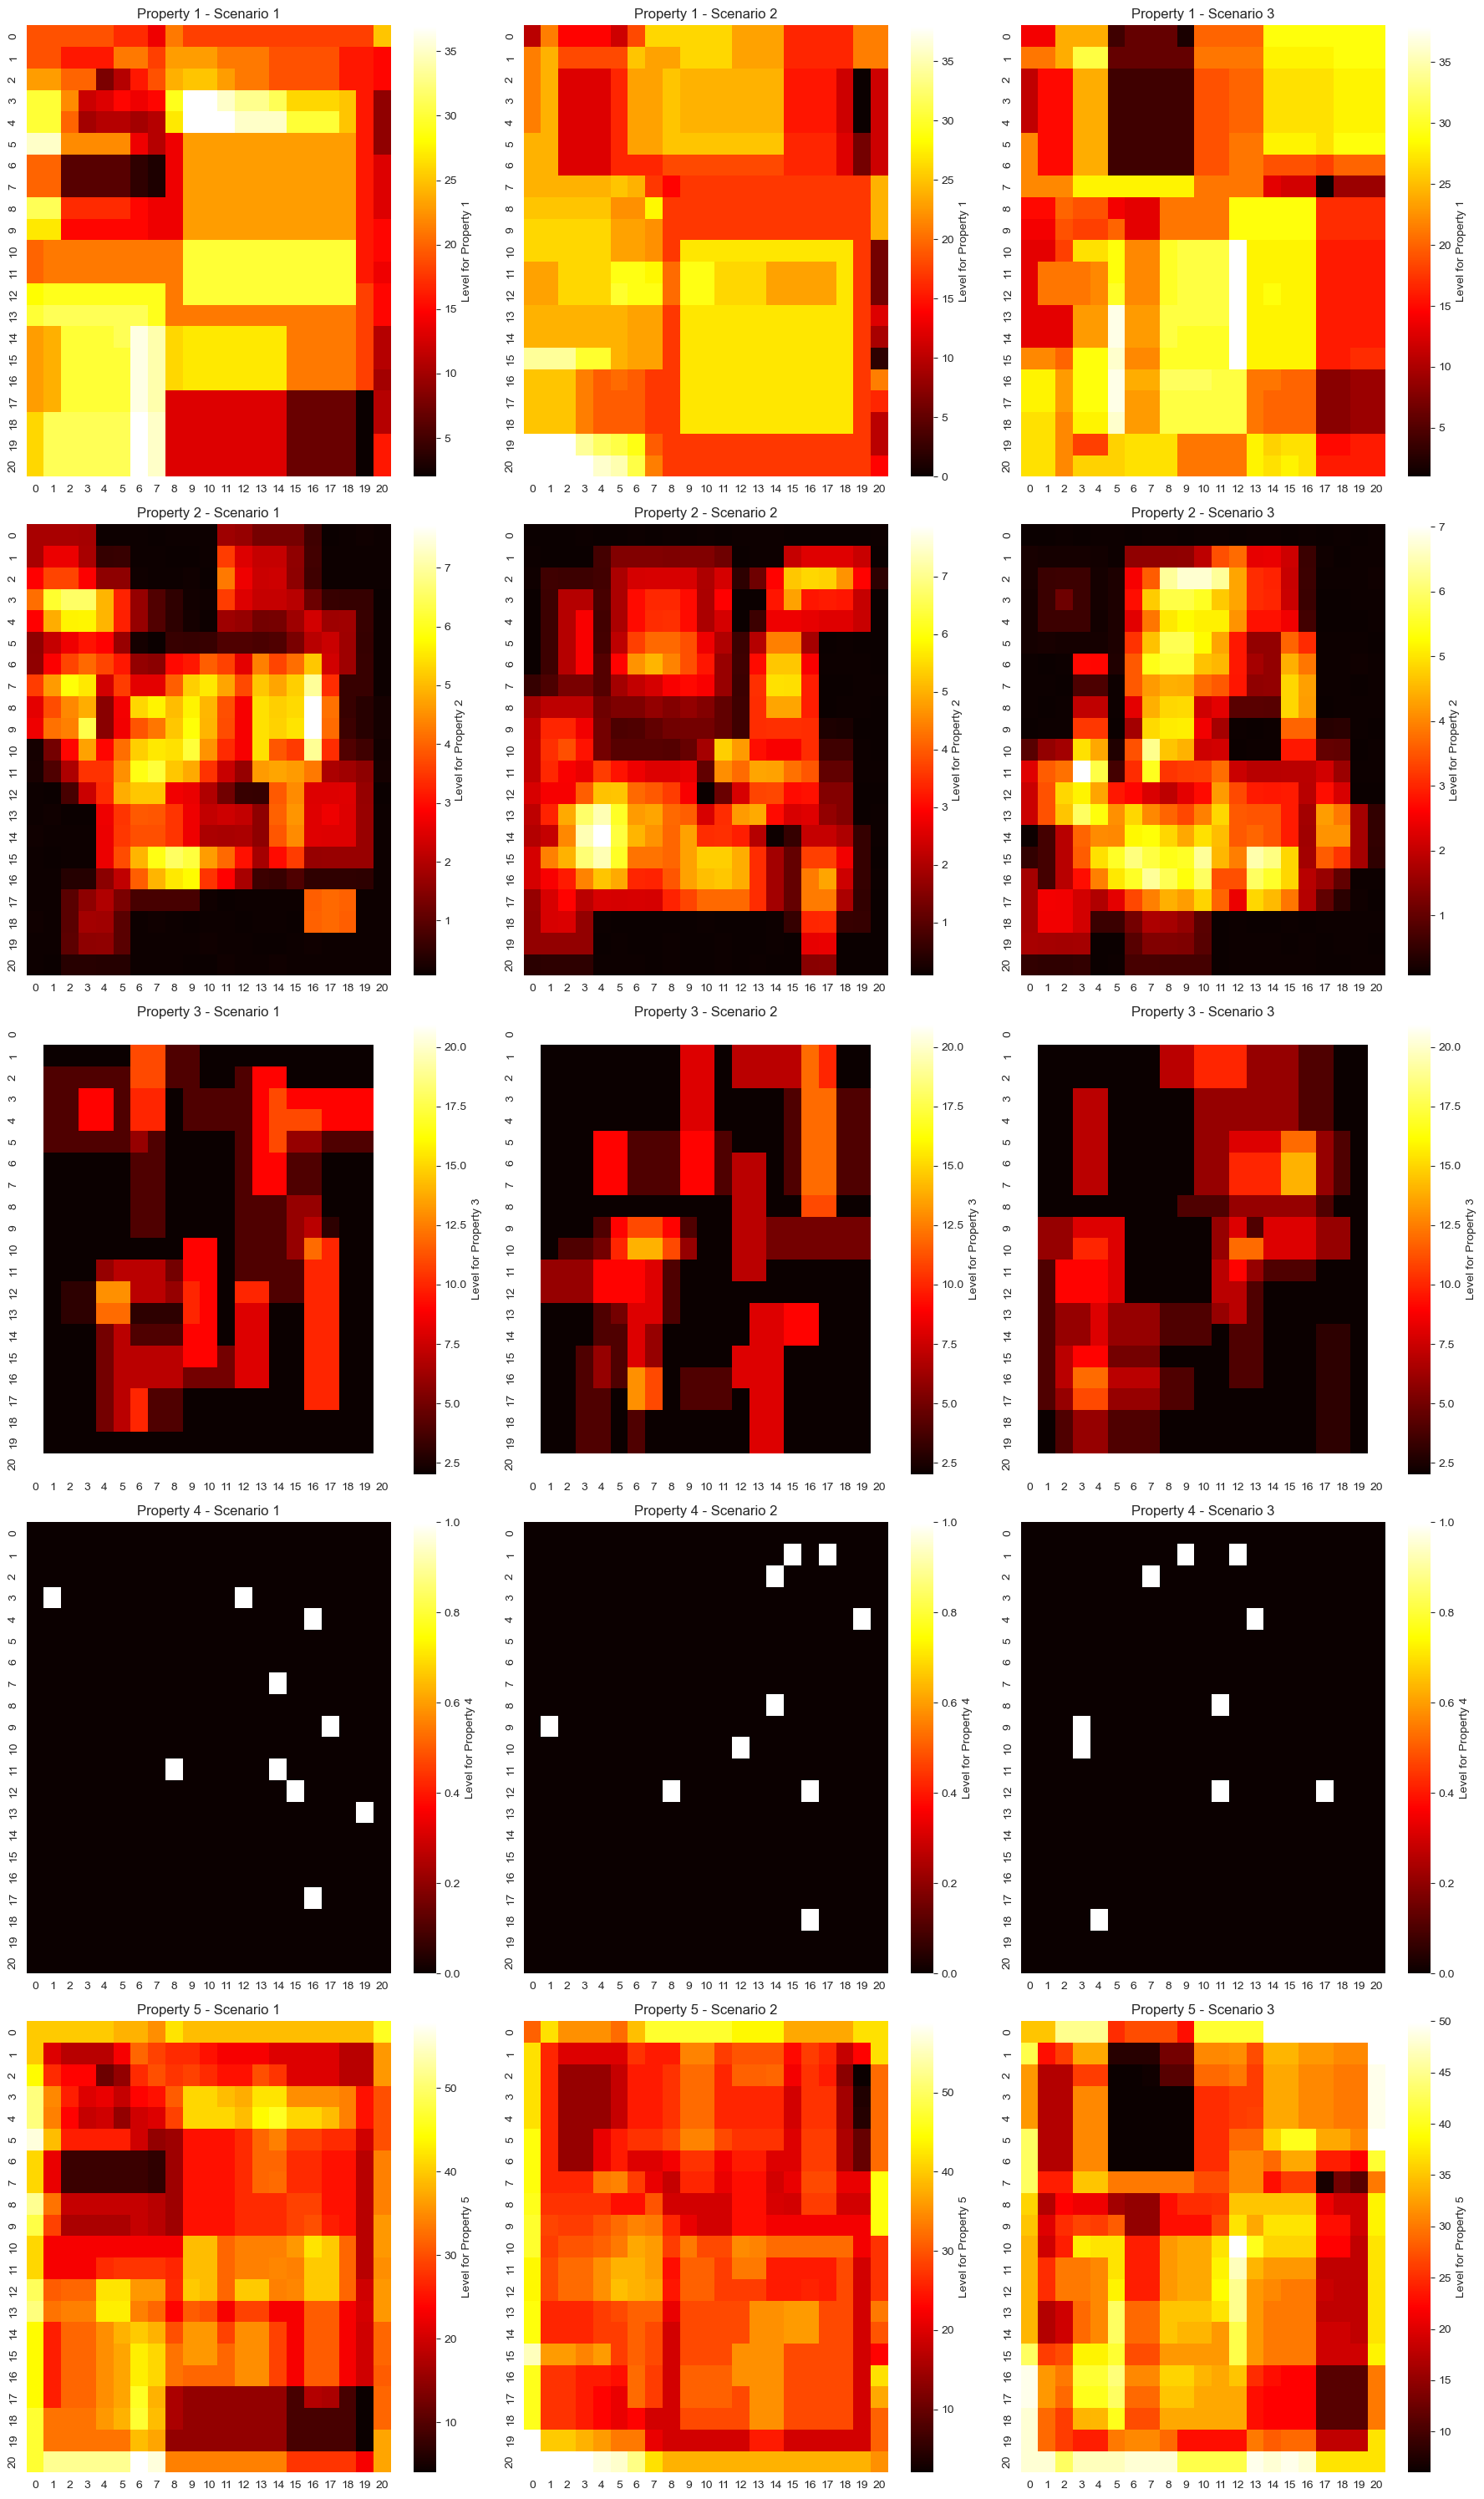

In [60]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from abc import ABC, abstractmethod
from collections import deque
from pettingzoo.classic import tictactoe_v3

from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
from functools import reduce
import operator
import seaborn as sns
import pandas as pd
import pickle

from torchrl.envs.libs import pettingzoo

torch.set_default_dtype(torch.half)

class Environment:
    def __init__(self, size=(21,21,21), diff=1, risk_prob=0.1, death_prob=0.01):
        self.size = size  # Grid size, e.g., (100, 100, 100) for 3D
        self.vol = size[0]*size[1]*size[2]
        self.diff = diff  # A difficulty or variability factor
        self.dim = len(size)
        self.target = (0, 0, 0, 0) # energy-p, wall-p, risk-p, death-p by volume or by cells, index by 0
        self.isRiskCluster = True
        
        # main game -> min (time(steps) * total_energy) -> compared with (l2_distance * harmonic_or_mean_or_70_or_max_energy). if agent_score < estimated_score, good. if a_s > e_s, improve. hm7m is param tightened by agent performance
        # minimize energy = main objective
        self.energy = torch.clamp(torch.normal(0.2, 0.5, size=self.size), min=0, max=3)
        # cannot transpose to wall, if slip into wall -> terminate , death ,-r
        self.wall = torch.zeros(size)
        # risk will lead to slip to a random neighbor cell
        self.risk = torch.mul(torch.rand(size), risk_prob)
        # if death will terminal state, negative reward (-r)
        self.death = torch.mul(self.risk, death_prob)

        self.set_diff()
        self.init_properties()
        self.map = torch.add(torch.add(self.energy.clone(), self.wall.clone()),torch.mul(self.death.clone(), self.risk.clone()))

    def set_diff(self):
        print(self.vol)
        if self.diff == 1:
            self.target = (1, self.vol * 0.1, 0.1, 0.01)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

        if self.diff == 2:
            self.target = (1.2, self.vol * 0.2, 0.2, 0.05)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

        if self.diff == 3:
            self.target = (2, self.vol * 0.3, 0.3, 0.1)
            print("Setting Diff: ", self.diff, " -> ", self.target)
            return

    def init_properties(self):
        # Initialize grids with normal distributions
        volume = reduce(operator.mul, self.size, 1)
        print("INIT: Volume", volume)
        print("INIT: target: ", self.target)
        mask_r = int(max(self.size) * 0.1) #70% limit of any dim

        def create_hot_tensor(shape, min_value, max_value):
            dims = len(shape)
            ranges = [torch.arange(s, dtype=torch.float16) - (s - 1) / 2.0 for s in shape]
            grid = torch.meshgrid(ranges, indexing='ij')
            dist_matrix = torch.stack([torch.abs(grid[dim]) for dim in range(dims)]).max(0).values
            steps = max((s - 1) / 2 for s in shape)
            increment = (max_value - min_value) / steps if steps != 0 else 0
            values = min_value + (steps - dist_matrix) * increment
            values = torch.clamp(values, min=min_value, max=max_value).int()  # Ensure values are within specified range
            return values

        def set_random_dim_to_one(size):
            return tuple(np.where(np.arange(len(size)) == np.random.randint(len(size)), 2, size))

        def apply_hot_region(tensor, center, size, min_value, max_value, mode):
            if mode == 0:
                hot_tensor = create_hot_tensor(size, min_value, max_value)
            elif mode == 1:
                size = set_random_dim_to_one(size) # shrink size by x dim
                hot_tensor = torch.ones(size)

            # Calculate slice for each dimension for the parent tensor
            parent_slices = []
            hot_tensor_slices = []

            for c, s, es in zip(center, size, tensor.shape):
                # Start and end points for the slice on the parent tensor
                start = max(0, c - s // 2)
                end = min(c + (s + 1) // 2, es)

                # Corresponding start and end points on the hot_tensor
                hot_start = max(0, s // 2 - c if c < s // 2 else 0)
                hot_end = s - max(0, (c + (s + 1) // 2) - es)

                # Append the slices to the lists
                parent_slices.append(slice(start, end))
                hot_tensor_slices.append(slice(hot_start, hot_end))

            # Convert lists to tuples
            parent_slices = tuple(parent_slices)
            hot_tensor_slices = tuple(hot_tensor_slices)

            # Place the correctly sliced hot_tensor into the parent tensor
            tensor[parent_slices] = hot_tensor[hot_tensor_slices]
            return tensor

        def set_tensor_edges_to_one(tensor):
            """
            Sets the edges of an n-dimensional tensor to 1.
        
            Args:
            - tensor (torch.Tensor): An n-dimensional tensor.
        
            Returns:
            - torch.Tensor: The modified tensor with its edges set to 1.
            """
            # Iterate over each dimension and set the edge indices to 1
            for dim in range(tensor.ndim):
                # Get a list of all slice(None) initially which means select everything along each dimension
                indexer = [slice(None)] * tensor.ndim

                # Set the first and last index of the current dimension to 1
                indexer[dim] = 0
                tensor[tuple(indexer)] = 1
                indexer[dim] = -1
                tensor[tuple(indexer)] = 1

            return tensor

        def rand_center(tensor, r):
            # Ensure that the generated center is at least `r` away from the edges of the tensor
            return tuple(np.random.randint(low=r, high=dim-r) if dim > 2 * r else r for dim in tensor.shape)

        def tensor_vol(dim, vol):
            k = 1
            random_matrix = torch.clamp(torch.rand(dim), max=k)
            return tuple(torch.round(random_matrix * vol).int().tolist())

        print("INIT: Energy", self.energy.mean() > self.target[0])
        energy_flag = True
        i = 0
        while energy_flag:
            self.energy = apply_hot_region(
                self.energy,
                rand_center(self.energy, mask_r),
                tensor_vol(self.dim, self.vol * 0.003),
                0,
                3,
                mode=0
            )
            i += 1
            if (self.energy.mean() > self.target[0]) or (i==50000):
                energy_flag = False
                print("if ", self.energy.mean() > self.target[0]," or ", (i==50000), "flag: ", energy_flag)
                print("self.energy.mean: ", self.energy.mean())

        print("INIT: Wall", self.wall.sum() > (self.target[1]))
        wall_flag = True
        i = 0
        while wall_flag:
            self.wall = apply_hot_region(
                self.wall,
                rand_center(self.wall, mask_r),
                tensor_vol(self.dim, self.vol * 0.001),
                1,
                1,
                mode=1
            )
            i += 1
            if (self.wall.sum() > self.target[1]) or (i==10000):
                wall_flag = False
                print("if ", self.wall.sum() > self.target[1]," or ", (i==10000), "-> flag: ", wall_flag)
                self.wall = set_tensor_edges_to_one(self.wall.clone())
                self.wall = torch.bernoulli(self.wall)

        print("INIT: Risk", self.risk.mean() > (self.target[2]))
        risk_flag = True
        i = 0
        if self.isRiskCluster:
            while risk_flag:
                self.risk = apply_hot_region(
                    self.risk,
                    rand_center(self.risk, mask_r),
                    tensor_vol(self.dim, self.vol * 0.001),
                    1,
                    10,
                    mode=0
                )
                i += 1
                if (self.risk.mean()/10 > self.target[2]) or (i==10000):
                    risk_flag = False
                    print("if ", self.risk.mean()/10 > self.target[2]," or ", (i==10000), "flag: ", risk_flag)
                    self.risk = torch.mul(self.risk, 0.1)

        print("INIT: Death", self.risk.mean() * self.target[3])
        self.death = torch.bernoulli(torch.mul(self.risk, self.target[3]))

    def env_global_features(self, len=3):
        # Function to calculate feature sums for all axes
        def compress_nd_matrix_sum(data) -> torch.tensor:
            """
            Compress an n-dimensional matrix by summing along each axis using PyTorch.

            Parameters:
                data (torch.Tensor): An n-dimensional PyTorch tensor.
            """
            n_dimensions = data.ndim
            compressed_results = []
            for axis in range(n_dimensions):
                # Sum along the current axis and store the result
                axis_sum = torch.sum(data, dim=axis)
                compressed_results.append(axis_sum)
            return torch.stack(compressed_results)

        if len == 1:
            return torch.stack([compress_nd_matrix_sum(self.map.clone())
                                ])
        elif len == 2:
            return torch.stack([compress_nd_matrix_sum(self.map.clone()),
                                compress_nd_matrix_sum(self.wall.clone())
                                ])
        elif len == 3:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                ])
        elif len == 4:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                compress_nd_matrix_sum(self.death.clone())
                                ])
        elif len == 5:
            return torch.stack([compress_nd_matrix_sum(self.energy.clone()),
                                compress_nd_matrix_sum(self.risk.clone()),
                                compress_nd_matrix_sum(self.wall.clone()),
                                compress_nd_matrix_sum(self.death.clone()),
                                compress_nd_matrix_sum(self.map.clone())
                                ])

    def env_local_state(self, loc, len=3):
        def return_stack(loc, len=3):
            if len == 1:
                return torch.stack([pad_local_state(self.map.clone(), loc, len)
                                    ])
            elif len == 2:
                return torch.stack([pad_local_state(self.map.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len)
                                    ])
            elif len == 3:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len)
                                    ])
            elif len == 4:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len),
                                    pad_local_state(self.death.clone(), loc, len)
                                    ])
            elif len == 5:
                return torch.stack([pad_local_state(self.energy.clone(), loc, len),
                                    pad_local_state(self.risk.clone(), loc, len),
                                    pad_local_state(self.wall.clone(), loc, len),
                                    pad_local_state(self.death.clone(), loc, len),
                                    pad_local_state(self.map.clone(), loc, len)
                                    ])

        def pad_local_state(input_tensor, location, distance):
            # Create slice objects for each dimension
            dim = input_tensor.dim()
            slices = []
            for i in range(dim):
                start = location[i] - distance
                end = location[i] + distance + 1  # +1 for exclusive end
                slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

            # Extract the slice from the tensor
            extracted = input_tensor[slices]

            # Determine the shape of the full result with padding
            full_shape = [2 * distance + 1] * dim

            # Create a tensor of zeros with the target shape
            result = torch.zeros(full_shape)

            # Calculate the slices for inserting the extracted data into the result
            insert_slices = [slice(max(0, distance - (location[i] - slices[i].start)),
                                   max(0, distance - (location[i] - slices[i].start)) + extracted.size(i)) for i in range(dim)]

            # Place the extracted slice into the padded result tensor
            result[insert_slices] = extracted

            return result

        return return_stack(loc, len)

    def roll(self, location):
        if self.risk[location] > torch.rand(1):
            return True, self.risk[location]
        else:
            return False, self.risk[location]

    def _get_cell(self, location):
        return self.risk[location], self.energy[location], self.wall[location], self.death[location]

    def cell_cost(self, location):
        tuple(self._get_cell(location))

class MiniGame:
    def __init__(self):
        self.env = tictactoe_v3.env(render_mode="human")
        self.env.reset(seed=42)
        # opt adam or RMSPrompt, Adam dynamic gradient may be bad for pomdp

        for agent in self.env.agent_iter():
            observation, reward, termination, truncation, info = self.env.last()

            if termination or truncation:
                action = None
            else:
                mask = observation["action_mask"]
                # this is where you would insert your policy
                action = self.env.action_space(agent).sample(mask)

            self.env.step(action)
        self.env.close()
        pass

class Agent(ABC):
    def __init__(self, start_pos, end_pos, team, action_size, state_size, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000):
        self.action_size = action_size
        self.state_size = state_size
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.start_pos = start_pos
        self.current_pos = start_pos
        self.request_pos = start_pos
        self.end_pos = end_pos
        self.team = team
        self.history = None
        self.state = None
        self.action = None

    def lyapunov(self):
        return

    def safety_soft(self, state, action):
        return action
    
    def CLF(self):
        # should assess next worst possible state.
        # Theorm -> agent in a ok state should not die because of a nudge
        # like balancing a bottle, bottle at stable state ss should not fall down when k force is applied leading it to state sa or sb, however sc may be dangerous and sf is prohibited.
        return

    def safety_hard(self, state, action):
        if violate:
            return True
        
        return False


    def expect(self, state, action):
        return
    
    @abstractmethod
    def get_action(self, state):
        """
        Get the action to take based on the current state.

        Args:
            state: The current state in the environment.

        Returns:
            An integer representing the chosen action.
        """
        pass

    @abstractmethod
    def update_model(self, state, action, reward, next_state, done):
        """
        Update the model based on the transition.

        Args:
            state: The current state from which the action was taken.
            action: The action taken.
            reward: The reward received after taking the action.
            next_state: The state transitioned to after the action.
            done: Boolean indicating if the episode has terminated.
        """
        pass

    @abstractmethod
    def train(self):
        """
        Train the agent using experiences stored in memory.
        """
        pass
 
class NN(nn.Module):
    def __init__(self, input, output, mode=0):
        # https://r-knott.surrey.ac.uk/Fibonacci/fibtable.html
        if mode == 0:
            super(NN, self).__init__()
            self.layer[0] = nn.Linear(input, 610),
            self.layer[1] = nn.SELU(),
            self.layer[2] = nn.Linear(610, 377),
            self.layer[3] = nn.SELU(),
            self.layer[4] = nn.Linear(377, 144),
            self.layer[5] = nn.SELU(),
            self.layer[6] = nn.Linear(144, 233),
            self.layer[7] = nn.SELU(),
            self.layer[8] = nn.Linear(233, output),
            self.layer[9] = nn.Softmax(dim=-1)
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        elif mode == 1:
            # dummy for random
            pass

    def forward(self, x):
        pass

class PGAAPP(Agent, NN):
    def __init__(self, start_pos, end_pos, team, policy_type):
        pass
    
class DQN(Agent, NN):
    def __init__(self, start_pos, end_pos, team, policy_type):
        pass
    
class Observer:
    def __init__(self):
        self.env = Environment()
        self.log = 
        self.MARL = True
        self.LoadMap = False
        self.LoadNavModel = False
        self.LoadPvPModel = False
        self.ResumeNav = False
        self.ResumePvP = False
        
        #agent = Agent(start_pos=(0, 0), end_pos=(9, 9), environment=self.env, team=1)

    def plot_space(self, mode):
        if mode == 0:
            print("env.energy: ", self.env.energy.min(), self.env.energy.mean(), self.env.energy.max())
            ipv.figure()
            ipv.volshow(self.env.energy, level=[0.1, 0.5, 0, 1, 3], opacity=0.03, level_width=0.1, data_min=self.env.energy.min(), data_max=self.env.energy.max())
            ipv.show()

        if mode == 1:
            print("env.wall: ", self.env.wall.sum())
            ipv.figure()
            ipv.volshow(self.env.wall, level=[0, 1], opacity=0.05, level_width=0.1, data_min=self.env.wall.min(), data_max=self.env.wall.max())
            ipv.show()

        if mode == 2:
            print("env.risk: ", self.env.risk.min(), self.env.risk.mean(), self.env.risk.max())
            ipv.figure()
            ipv.volshow(self.env.risk, level=[0, 0.25, 0.5, 0.75, 1], opacity=0.05, level_width=0.1, data_min=self.env.risk.min(), data_max=self.env.risk.max())
            ipv.show()

        if mode == 3:
            print("env.death: ", self.env.death.min(), self.env.death.mean(), self.env.death.max())
            ipv.figure()
            ipv.volshow(self.env.death, opacity=0.05, level_width=0.1, data_min=self.env.death.min(), data_max=self.env.death.max())
            ipv.show()

        if mode == 4:
            print("env.map: ", self.env.map.min(), self.env.map.mean(), self.env.map.max())
            ipv.figure()
            ipv.volshow(self.env.map, opacity=0.05, level_width=0.1, data_min=self.env.map.min(), data_max=self.env.map.max())
            ipv.show()

    def plot_slice(self, mode, loc=[14, 14, 7], r=7):
        if mode == 0:
            print("env.energy.slice: ")
            ipv.figure()
            ipv.volshow(self.env.energy[loc[0]-r:loc[0]+r, loc[1]-r:loc[1]+r, loc[2]-r:loc[2]+r], level=[0.1, 0.5, 0, 1, 3], opacity=0.03, level_width=0.1, data_min=0, data_max=3)
            ipv.show()

        if mode == 1:
            print("env.wall.slice: ")
            ipv.figure()
            ipv.volshow(self.env.wall[loc[0]-r:loc[0]+r, loc[1]-r:loc[1]+r, loc[2]-r:loc[2]+r], level=[0, 1], opacity=0.05, level_width=0.1, data_min=0, data_max=1)
            ipv.show()

        if mode == 2:
            print("env.risk.slice: ")
            ipv.figure()
            ipv.volshow(self.env.risk[loc[0]-r:loc[0]+r, loc[1]-r:loc[1]+r, loc[2]-r:loc[2]+r], level=[0, 0.25, 0.5, 0.75, 1], opacity=0.05, level_width=0.1, data_min=0, data_max=1)
            ipv.show()

    def plot_features(self, len=3):
        # Obtain data from your environment function
        tensors = self.env.env_global_features(len)
        print("features.shape is: ", tensors.shape)
        # Determine the number of properties and scenarios dynamically
        num_properties, num_scenarios, _, _ = tensors.shape  # Assume shape is [num_properties, num_scenarios, 10, 10]

        # Prepare property names dynamically (if they are not predefined)
        property_names = [f'Property {i+1}' for i in range(num_properties)]

        # Set up the figure based on the number of properties and scenarios
        fig, axs = plt.subplots(num_properties, num_scenarios, figsize=(num_scenarios*6, num_properties*6))

        # Check if we have a single row or column to adjust indexing
        if num_properties == 1 or num_scenarios == 1:
            axs = axs.reshape(num_properties, num_scenarios)

        # Loop through each property and scenario
        for i in range(num_properties):
            for j in range(num_scenarios):
                ax = axs[i, j]
                sns.heatmap(tensors[i, j], cmap='hot', ax=ax, cbar_kws={'label': f'Level for {property_names[i]}'})
                ax.set_title(f'{property_names[i]} - Scenario {j+1}')

        plt.tight_layout()  # Adjust subplots to fit into figure area.
        plt.show()  # Show the plot

    def observation(self, location, target, obs=3, k=3):
        # Method to build obs for NAVagent 
        def obs_map(loc, obs, k):
            # 21 * 21 obs 441 pooled by k=3 to 49
            mean_egf = F.avg_pool2d(self.env.env_global_features(len=obs), kernel_size=k, stride=k)
            # map: map,wall: energy,risk,wall: || 1->147, 2->294, 3->441
            # energy,risk,wall,death: energy,risk,wall,death,map || 4->588, 5->735
            # build local exact highres observation with vision 5
            tensor_map = self.env.env_local_state(location, len=obs)
            # returns the global foggy look and the local true observation
            return torch.cat([mean_egf.flatten(), tensor_map.flatten()])
        
        def obs_nav(location, target):
            # builds the relative properties for the NN, eg abs distance from target
            return torch.cat([torch.tensor(location == target).flatten(), 
                              torch.tensor(target - location).flatten()])
        
        return torch.cat([obs_map(location, obs, k), obs_nav(torch.tensor(location), torch.tensor(target))])

    def train(self):
        # trains agents
        # assign Policy, Agent pairs
        # 
        return
    
    def review(self):
        # snapshot environment
        
    def review_PA(self):
        # check policy agent pairs and compare with different PA pairs
        return

if __name__ == "__main__":
    obs = Observer()
    #obs.plot_space(0)
    #obs.plot_space(1)
    #obs.plot_space(2)
    #obs.plot_space(3)
    #obs.plot_space(4)
    obs.plot_features(5)
    

In [62]:
    actual_slice = obs.observation(location=[14, 14, 7], target=[2, 18, 7], obs=3, k=3)
    print(actual_slice.shape)

torch.Size([1476])


/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_29680/3713200892.py:515: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat([torch.tensor(location == target).flatten(),
/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_29680/3713200892.py:516: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target - location).flatten()])


In [59]:
location=torch.tensor([14, 14, 7])
target=torch.tensor([2, 18, 7])

#arrive = torch.tensor(location == target).flatten()
#delta = torch.tensor(target - location).flatten()
b = torch.cat([torch.tensor(location.clone() == target.clone()).clone().flatten(), torch.tensor(target.clone() - location.clone()).clone().flatten()])
b.size()

/var/folders/lv/d9bgbh6s4vl8kfgyydwn949c0000gn/T/ipykernel_29680/4293054050.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.cat([torch.tensor(location.clone() == target.clone()).clone().flatten(), torch.tensor(target.clone() - location.clone()).clone().flatten()])


torch.Size([6])

In [13]:
import torch
import ipyvolume as ipv

def pad_local_state(input_tensor, distance, location):
    # Create slice objects for each dimension
    dim = input_tensor.dim()
    slices = []
    for i in range(dim):
        start = location[i] - distance
        end = location[i] + distance + 1  # +1 for exclusive end
        slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

    # Extract the slice from the tensor
    extracted = input_tensor[slices]

    # Determine the shape of the full result with padding
    full_shape = [2 * distance + 1] * dim

    # Create a tensor of zeros with the target shape
    result = torch.zeros(full_shape)

    # Calculate the slices for inserting the extracted data into the result
    insert_slices = [slice(max(0, distance - (location[i] - slices[i].start)),
                           max(0, distance - (location[i] - slices[i].start)) + extracted.size(i)) for i in range(dim)]

    # Place the extracted slice into the padded result tensor
    result[insert_slices] = extracted
    
    return result

def extract_and_pad(input_tensor, distance, location):
    # Ensure input_tensor is a PyTorch tensor and location is a tuple
    input_tensor = torch.as_tensor(input_tensor)
    location = tuple(location)

    # Initialize slices for each dimension
    slices = []
    for i, loc in enumerate(location):
        # Calculate start and end indices for each dimension
        start = loc - distance
        end = loc + distance + 1  # +1 for exclusive end

        # Create a slice object for each dimension
        slices.append(slice(max(0, start), min(input_tensor.size(i), end)))

    # Extract the slice from the tensor
    extracted = input_tensor[slices]

    # Determine the shape of the full result with padding
    full_shape = [2 * distance + 1] * input_tensor.dim()

    # Create a tensor of zeros with the target shape
    result = torch.zeros(full_shape, dtype=input_tensor.dtype, device=input_tensor.device)

    # Calculate the slices for inserting the extracted data into the result
    insert_slices = []
    for i, slc in enumerate(slices):
        start_idx = max(0, distance - location[i])
        end_idx = start_idx + (slc.stop - slc.start)
        insert_slices.append(slice(start_idx, end_idx))

    # Place the extracted slice into the padded result tensor
    result[insert_slices] = extracted

    return result


# Sample tensor and parameters
sample_tensor = torch.ones(21, 21, 21)  # Example tensor

# Test with different 'dimensions' parameter
#padded_slice_2 = extract_and_pad(sample_tensor, [10, 10], 3, sample_tensor.dim(), 2)
padded_slice_4 = extract_and_pad(sample_tensor, 3, [1, 20, 1])

ps5 = pad_local_state(sample_tensor, 3, [1, 20, 1])

print(ps5 == padded_slice_4)
# Output shapes
#print("Shape with last 2 dimensions processed:", padded_slice_2.shape)
print("Shape with last 4 dimensions processed:", padded_slice_4.shape, padded_slice_4.min(), padded_slice_4.mean(), padded_slice_4.max())



tensor([[[True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True],
         [True, True, True, True, True, Tr

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

In [ ]:
t = torch.full((8, 8), 0.5)
torch.bernoulli(t).count_nonzero()

In [ ]:
import torch
import torch.nn.functional as F

# Create a sample tensor of shape [5, 3, 21, 21]
x = torch.randn(5, 3, 21, 21)

# Apply average pooling
x_mean_pooled = F.avg_pool2d(x, kernel_size=3, stride=3)
print(x_mean_pooled.shape)


In [ ]:
import torch

def fill_hypercube(tensor, center, radius):
    """
    Fill a hypercube area of a tensor with ones, centered at `center` with the specified `radius`.

    Parameters:
        tensor (torch.Tensor): An n-dimensional tensor.
        center (tuple): A tuple representing the center of the hypercube.
        radius (int): The radius of the hypercube to fill.

    Returns:
        torch.Tensor: The modified tensor with ones in the specified hypercube area.
    """
    # Generate slices for each dimension
    slices = []
    for i, c in enumerate(center):
        start = max(c - radius, 0)
        end = min(c + radius + 1, tensor.size(i))
        slices.append(slice(start, end))

    # Use tuple of slices to modify the tensor
    tensor[tuple(slices)] = 1
    return tensor

# Example usage:
tensor = torch.zeros(5, 5, 5)  # A 3D tensor
center = (2, 2, 2)  # Center of the hypercube
radius = 1          # Radius of the hypercube

modified_tensor = fill_hypercube(tensor, center, radius)
print(modified_tensor)


In [36]:
import torch

# Define the modified function for extracting local observations
def extract_local_observation(properties, location, radius):
    num_properties, *dimensions = properties.shape
    assert len(location) == len(dimensions), "Location must match the number of spatial dimensions in properties."

    slices = []
    padding = []
    for dim, loc in zip(dimensions, location):
        low = max(loc - radius, 0)
        high = min(loc + radius + 1, dim)
        slices.append(slice(low, high))
        padding.append((max(radius - loc, 0), max(loc + radius + 1 - dim, 0)))

    local_observation = properties[(slice(None),) + tuple(slices)]
    padded_local_observation = torch.nn.functional.pad(local_observation, sum(padding[::-1], ()))

    return padded_local_observation

# Example 1: 3D Tensor
properties_3d = torch.rand(5, 10, 10, 10)  # Shape: (num_properties, x_dim, y_dim, z_dim)
location_3d = (5, 5, 5)
radius_3d = 2
extracted_3d = extract_local_observation(properties_3d, location_3d, radius_3d)
print("Extracted Shape (3D):", extracted_3d.shape)

# Example 2: 4D Tensor
properties_4d = torch.rand(3, 8, 8, 8, 8)  # Shape: (num_properties, x_dim, y_dim, z_dim, t_dim)
location_4d = (4, 4, 4, 4)
radius_4d = 1
extracted_4d = extract_local_observation(properties_4d, location_4d, radius_4d)
print("Extracted Shape (4D):", extracted_4d.shape)

# Example 3: 2D Tensor (edge case)
properties_2d = torch.rand(6, 15, 15)  # Shape: (num_properties, x_dim, y_dim)
location_2d = (7, 7)
radius_2d = 3
extracted_2d = extract_local_observation(properties_2d, location_2d, radius_2d)
print("Extracted Shape (2D):", extracted_2d.shape)


Extracted Shape (3D): torch.Size([5, 5, 5, 5])
Extracted Shape (4D): torch.Size([3, 3, 3, 3, 3])
Extracted Shape (2D): torch.Size([6, 7, 7])


In [ ]:
def set_tensor_edges_to_one(tensor):
    """
    Sets the edges of an n-dimensional tensor to 1.

    Args:
    - tensor (torch.Tensor): An n-dimensional tensor.

    Returns:
    - torch.Tensor: The modified tensor with its edges set to 1.
    """
    # Iterate over each dimension and set the edge indices to 1
    for dim in range(tensor.ndim):
        # Get a list of all slice(None) initially which means select everything along each dimension
        indexer = [slice(None)] * tensor.ndim

        # Set the first and last index of the current dimension to 1
        indexer[dim] = 0
        tensor[tuple(indexer)] = 1
        indexer[dim] = -1
        tensor[tuple(indexer)] = 1

    return tensor

tensor_3d = torch.zeros(7, 7, 7)  # Creating a 3D tensor filled with zeros
set_tensor_edges_to_one(tensor_3d)
print(tensor_3d)

In [ ]:
import numpy as np

def set_random_dim_to_one(size):
    return tuple(np.where(np.arange(len(size)) == np.random.randint(len(size)), 2, size))

# Example usage
size_tuple = (3, 5, 7)
new_size = set_random_dim_to_one(size_tuple)
print("Original size:", size_tuple)
print("Modified size:", new_size)


In [ ]:
import torch

def gaussian_tensor(size, std_dev):
    """
    Create an n-dimensional Gaussian tensor in PyTorch using vectorized operations.
    
    Args:
    size (tuple of ints): the size of the tensor for each dimension.
    std_dev (float): the standard deviation of the Gaussian distribution.

    Returns:
    torch.Tensor: an n-dimensional Gaussian tensor.
    """
    # Generate grid of indices for each dimension
    ranges = [torch.linspace(0, s-1, steps=s) for s in size]
    grid = torch.meshgrid(ranges, indexing='ij')
    
    # Calculate the center of the tensor
    center = torch.tensor([(s-1)/2 for s in size])
    
    # Compute squared distance from the center
    squared_distance = sum([(g - center[i])**2 for i, g in enumerate(grid)])
    
    # Apply the Gaussian formula
    gaussian = torch.exp(-0.5 * (squared_distance / std_dev**2))
    
    # Normalize to max value of 1
    gaussian = gaussian / torch.max(gaussian)
    
    return gaussian

# Example usage:
size = (3, 3, 3, 3)  # 3D tensor of size 10x10x10
std_dev = 1.0        # Standard deviation
tensor = gaussian_tensor(size, std_dev)
print(torch.round(tensor*9))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
g = 9.81  # gravity
l = 1.0   # length of pendulum
m = 1.0   # mass of pendulum
dt = 0.05 # time step
k1, k2 = 10, 1  # Lyapunov function coefficients

# Discretized Dynamics
def update_state(theta, theta_dot, u):
    theta_next = theta + dt * theta_dot
    theta_dot_next = theta_dot + dt * (g / l * theta + u / (m * l**2))
    return theta_next, theta_dot_next

# Lyapunov Function
def lyapunov(theta, theta_dot):
    return 0.5 * k1 * theta**2 + 0.5 * k2 * theta_dot**2

# Policy: Simple feedback to minimize Lyapunov function increase
def control_policy(theta, theta_dot):
    # Calculate necessary control to reduce Lyapunov function derivative
    return -1.5 * (g / l + k1 / k2) * theta * theta_dot

# Simulation
def simulate_pendulum(steps=200):
    theta, theta_dot = 0.2, 0  # small initial deviation from upright position
    history = []
    
    for _ in range(steps):
        u = control_policy(theta, theta_dot)
        theta, theta_dot = update_state(theta, theta_dot, u)
        history.append((theta, theta_dot, u))
        
    return history

# Run Simulation
history = simulate_pendulum()

# Plotting results
thetas, theta_dots, us = zip(*history)
t = np.arange(len(thetas)) * dt

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, thetas, label='Theta')
plt.ylabel('Angle (rad)')
plt.title('Pendulum Angle')

plt.subplot(312)
plt.plot(t, theta_dots, label='Theta Dot')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Pendulum Angular Velocity')

plt.subplot(313)
plt.plot(t, us, label='Control Input')
plt.ylabel('Torque (Nm)')
plt.title('Control Input Applied')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()


In [ ]:
%%time

def generate_binary_tensor(mean, shape):
    # Create a tensor filled with the specified mean
    probability_tensor = torch.full(shape, mean)
    # Use Bernoulli distribution to generate binary tensor
    binary_tensor = torch.bernoulli(probability_tensor)
    return binary_tensor

# Example usage
mean = 0.9999  # Proportion of ones
shape = (21, 21, 21)  # Shape of the tensor
for i in range(5000):
    tensor = generate_binary_tensor(mean, shape)
    
print(tensor.mean())
tensor.min()

In [ ]:
from vmas import make_env
from vmas.simulator.scenario import BaseScenario
from typing import Union
import time
import torch
from vmas import make_env
from vmas.simulator.core import Agent

def _get_deterministic_action(agent: Agent, continuous: bool, env):
    if continuous:
        action = -agent.action.u_range_tensor.expand(env.batch_dim, agent.action_size)
    else:
        action = (
            torch.tensor([1], device=env.device, dtype=torch.long)
            .unsqueeze(-1)
            .expand(env.batch_dim, 1)
        )
    return action.clone()

def use_vmas_env(
    render: bool,
    num_envs: int,
    n_steps: int,
    device: str,
    scenario: Union[str, BaseScenario],
    continuous_actions: bool,
    random_action: bool,
    **kwargs
):
    """Example function to use a vmas environment.
    
    This is a simplification of the function in `vmas.examples.use_vmas_env.py`.

    Args:
        continuous_actions (bool): Whether the agents have continuous or discrete actions
        scenario (str): Name of scenario
        device (str): Torch device to use
        render (bool): Whether to render the scenario
        num_envs (int): Number of vectorized environments
        n_steps (int): Number of steps before returning done
        random_action (bool): Use random actions or have all agents perform the down action

    """

    scenario_name = scenario if isinstance(scenario,str) else scenario.__class__.__name__

    env = make_env(
        scenario=scenario,
        num_envs=num_envs,
        device=device,
        continuous_actions=continuous_actions,
        seed=0,
        # Environment specific variables
        **kwargs
    )

    frame_list = []  # For creating a gif
    init_time = time.time()
    step = 0

    for s in range(n_steps):
        step += 1
        if step % 100 == 0:
            print(f"Step {step}")

        actions = []
        for i, agent in enumerate(env.agents):
            if not random_action:
                action = _get_deterministic_action(agent, continuous_actions, env)
            else:
                action = env.get_random_action(agent)

            actions.append(action)

        obs, rews, dones, info = env.step(actions)

        if render:
            frame = env.render(
                mode="rgb_array",
                agent_index_focus=None,  # Can give the camera an agent index to focus on
            )
            frame_list.append(frame)

    total_time = time.time() - init_time
    print(
        f"It took: {total_time}s for {n_steps} steps of {num_envs} parallel environments on device {device} "
        f"for {scenario_name} scenario."
    )

    if render:
        from moviepy.editor import ImageSequenceClip
        fps=30
        clip = ImageSequenceClip(frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)

In [ ]:
scenario_name="discovery"
use_vmas_env(
    scenario=scenario_name,
    render=True,
    num_envs=4096,
    n_steps=1000,
    device="cpu",
    continuous_actions=False,
    random_action=False,
    # Environment specific variables
    n_agents=4,
)

In [ ]:
def process_numbers(min=0, max=None):
    if max is None:
        # Handle the case where max is not provided
        print(f"Only min is specified: min={min}")
    else:
        # Both min and max are provided
        print(f"Min and max are specified: min={min}, max={max}")

# Example usage
process_numbers()          # Uses default min=0 and max=None
process_numbers(10)        # Uses min=10 and default max=None
process_numbers(10, 20)    # Uses min=10 and max=20


In [ ]:
import torch

# Example tensor
tensor = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)

# Threshold k
k = 3

# Zero out values below k
tensor[tensor < k] = 0
print(tensor)
